In [1]:
import numpy as np
import scipy as sp
from scipy import io,integrate,sparse
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

from spec_bin import *
#from lanczos_bin import mystep,distribution

from IPython.display import clear_output
np.set_printoptions(linewidth=300)
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['text.latex.preamble'] = r'\renewcommand{\vec}{\mathbf}'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [3]:
n = 10000
expr1 = {
    'lam': np.linspace(-1,1,n,endpoint=False)+1/n,
    'k_max': 50,
    'd': 500,
    'f': lambda x: 1/(1+16*x**2)
}

n = n//4
η=.25
expr2 = {
    'lam': np.hstack([np.linspace(-1,-1+η,n//2,endpoint=False)+η/n,\
                      np.linspace(1-η,1,n//2,endpoint=False)+η/n])
,
    'k_max': 50,
    'd': 500,
    'f': lambda x: 1/(1+16*x**2)
}

exprs = [expr1,expr2]

GQ_err = []
IQ_err = []
AQ_err = []
DAQ_err = []

for expr_idx,expr in enumerate(exprs):
    
    lam = expr['lam']
    k_max = expr['k_max']
    d = expr['d']
    n = len(lam)
    a,b = -1,1
    
    A = sp.sparse.spdiags(lam,0,n,n)

    v = np.ones(n)
    v/=np.linalg.norm(v)

    f = expr['f']

    
    GQ_err.append(np.full(k_max,np.nan))
    IQ_err.append(np.full(k_max,np.nan))
    AQ_err.append(np.full(k_max,np.nan))
    DAQ_err.append(np.full(k_max,np.nan))
    
    (α,β) = lanczos(A,v,k_max)
    (αro,βro) = lanczos_reorth(A,v,min(k_max,n),reorth=True)

    print(np.max(np.abs(α[:min(k_max,n)]-αro)),np.max(np.abs(αro)),\
          np.max(np.abs(β[:min(k_max,n)]-βro)),np.max(np.abs(βro)))
    
    αT = np.ones(max(2*k_max,d))*(a+b)/2
    βT = np.ones(max(2*k_max,d))*(b-a)/4
    βT[0] *= np.sqrt(2)
    m = get_chebyshev_moments(A,v,k_max,a,b)
    m_lan = get_moments_from_lanczos(A,v,2*k_max,αT,βT,T=(α,β))
    
    print(np.max(np.abs(m[:2*k_max]-m_lan[:2*k_max])))

    GQ_err[-1][0] = v.T@(f(lam)*v)
    IQ_err[-1][0] = v.T@(f(lam)*v)
    AQ_err[-1][0] = v.T@(f(lam)*v)
    DAQ_err[-1][0] = v.T@(f(lam)*v)
    for k in range(1,k_max):
        θ,ω = get_gq(k,α,β)
        GQ_err[-1][k] = ω@f(θ) - v.T@(f(lam)*v)

        s = 2*k
        θ,ω = get_iq(m,s,αT,βT)
        IQ_err[-1][k] = ω@f(θ) - v.T@(f(lam)*v)
    
        #d = s+1
        θ,ω = get_aaq(m,s,d,αT,βT)
        AQ_err[-1][k] = ω@f(θ) - v.T@(f(lam)*v)

        ρ = jackson_weights(s+1)
        θ,ω = get_aaq(ρ*m[:s+1],s,d,αT,βT)
        DAQ_err[-1][k] = ω@f(θ) - v.T@(f(lam)*v)

5.273559366969494e-16 5.273559366969494e-16 1.1102230246251565e-16 0.5773502663028741
1.905485318143274e-15
1.540868127536399e-15 2.0649714577158917e-15 2.220446049250313e-16 0.8779711441727451
5.218048215738236e-15


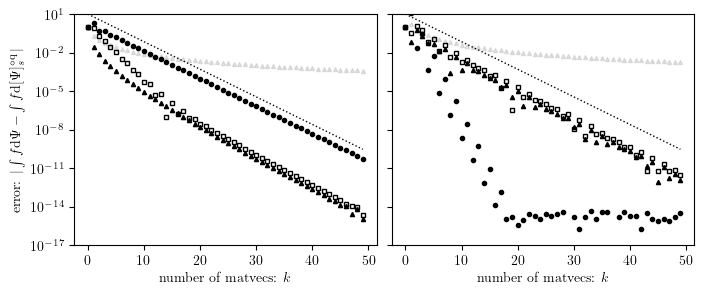

In [4]:
fig,axs = plt.subplots(1,2,figsize=(8,3),sharey=True)
fig.subplots_adjust(wspace=0.05)

for expr_idx,expr in enumerate(exprs):
    
    lam = expr['lam']
    k_max = expr['k_max']
    n = len(lam)
    a,b = min(lam),max(lam)
    
    axs[expr_idx].plot(np.abs(GQ_err[expr_idx])/np.abs(GQ_err[expr_idx])[0],label='GQ',marker='o',ms=3,ls='None',color='k')
    axs[expr_idx].plot(np.abs(IQ_err[expr_idx])/np.abs(IQ_err[expr_idx])[0],label='IQ',marker='s',ms=3,ls='None',fillstyle='none',color='k')
    axs[expr_idx].plot(np.abs(AQ_err[expr_idx])/np.abs(AQ_err[expr_idx])[0],label='AQ',marker='^',ms=3,ls='None',color='k')

    axs[expr_idx].plot(np.abs(DAQ_err[expr_idx])/np.abs(DAQ_err[expr_idx])[0],label='DAQ',marker='^',alpha=.1,ms=3,ls='None',color='k')
#    axs[expr_idx].plot(np.abs(HQ_err[expr_idx]),label='HQ',marker='.')

ρ=(1+np.sqrt(17))/4

axs[0].plot(10*ρ**(-2*np.arange(k_max)),label='rate',color='k',ls=':',lw=1)
axs[1].plot(10*ρ**(-2*np.arange(k_max)),label='rate',color='k',ls=':',lw=1)

axs[0].set_xlabel('number of matvecs: $k$')
axs[1].set_xlabel('number of matvecs: $k$')
axs[0].set_ylabel(r'error: $|\int f \mathrm{d}\Psi-\int f \mathrm{d}[\Psi]_s^{\circ\mathrm{q}}\,|$')

axs[0].set_yscale('log')
axs[0].set_ylim(1e-17,1e1)

plt.savefig('imgs/GQ_CC_tre08.pdf',bbox_inches='tight')